# Gesture Recognition

A home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command that are as followed:

Gesture | Action
--------|--------
Thumbs up |  Increase the volume
Thumbs down | Decrease the volume
Left swipe | 'Jump' backwards 10 seconds
Right swipe | 'Jump' forward 10 seconds  
Stop | Pause the movie
<br>


### Objectives:<br>
1. **Generator:** The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully. <br>

2. **Model:** Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further. <br>

3. **Write up:** This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.<br>

### Importing Packages and setting up seed value

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import os
import matplotlib.pyplot as plt
from imageio import imread
from skimage import io, transform
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 400)

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

#### Initialize path and vairables

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

# Batch size handled in class

batch_size = 30  # Will be passed to function run_model
img_size_ht = 120
img_size_wd = 120

### Defining Generator Function

In [24]:
def generator(source_path, folder_list, batch_size, factor_ht=0, factor_wd=0 ):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = np.arange(0,30,2) #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)


        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] /255.0
                    batch_data[folder,idx,:,:,1] = image[:,:,1] /255.0
                    batch_data[folder,idx,:,:,2] = image[:,:,2] /255.0
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                   # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
                    image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            

#### Defining Fit function for the models

In [25]:
def run_model(model, batch_size = 30, epoch_num=25, factor_ht=0, factor_wd=0):
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        train_generator = generator(train_path, train_doc, batch_size,factor_ht, factor_wd)
        val_generator = generator(val_path, val_doc, batch_size, factor_ht, factor_wd)
        
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5) # write the REducelronplateau code here
        
        callbacks_list = [checkpoint, LR]
        
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
       
        # Let us now fit the model. This will start training the model and with the help of the checkpoints, 
        # you'll be able to save the model at the end of each epoch.
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch_num, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
        return history

#### Defining Loss function that will be used to plot the graph

In [26]:
def loss(history):
        acc = history.history['categorical_accuracy']
        val_acc = history.history['val_categorical_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(len(history.history['loss']))

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

**More parameters**

In [27]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40 # choose the number of epochs. However this is a variable that can be passed to function run_model
print ('# epochs =', num_epochs)
num_classes = 5

# training sequences = 663
# validation sequences = 100
# epochs = 40


### Testing Generator function

Source path =  Project_data/train ; batch size = 32


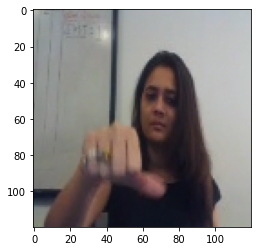

In [28]:
# Test Generator Function

xtrain=generator(train_path,train_doc, 32 )
x=next(xtrain)
plt.imshow(x[0][1][1])
plt.show()

Source path =  Project_data/train ; batch size = 32


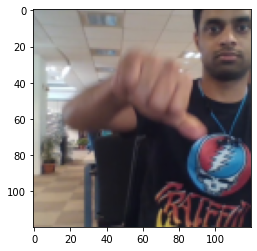

In [29]:
# Test Crop in Generator Function

xtrain=generator(train_path,train_doc, 32, factor_ht=10, factor_wd=10)
x=next(xtrain)
plt.imshow(x[0][1][1])
plt.show()

### Define Keras Classes

In [30]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, LeakyReLU
from tensorflow.keras.applications import EfficientNetB0

# Developing Models

**Note:** Only Top 5 models are presented here. Other models can be referred at: <br><br>
https://github.com/Ashit-Aggarwal/Data-Science/tree/main/Deep%20Learning/Gensture%20Recognition/Other%20Models

### Model 1 
- Activation Function used is LeakyRelu
- Optimizer used is Adam


In [11]:
# Define Model

model_1 = Sequential()
lrelu = lambda x: LeakyReLU(alpha=0.1)(x)

model_1.add(Conv3D(8,(3,3,3),   padding='same', input_shape= (15,img_size_ht,img_size_wd,3) ))
model_1.add(BatchNormalization())
model_1.add(Activation(lrelu))
model_1.add(MaxPooling3D(pool_size= (2,2,2)))

model_1.add(Conv3D(16,(3,3,3),padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation(lrelu))
model_1.add(MaxPooling3D(pool_size= (2,2,2)))

model_1.add(Conv3D(32,(1,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation(lrelu))
model_1.add(MaxPooling3D(pool_size= (2,2,2)))

model_1.add(Conv3D(64,(1,2,2), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation(lrelu))
model_1.add(MaxPooling3D(pool_size= (1,3,3)))

model_1.add(Flatten())

model_1.add(Dense(1000, activation=lrelu))
model_1.add(Dropout(0.5))

model_1.add(Dense(500, activation=lrelu))
model_1.add(Dropout(0.5))

model_1.add(Dense(5, activation='softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 16)     3472      
                                                                 
 batch_normalization_1 (Batc  (None, 7, 60, 60, 16)    6


Epoch 11: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
23/23 [==============================] - 158s 7s/step - loss: 0.4949 - categorical_accuracy: 0.8145 - val_loss: 3.4210 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 12/40
23/23 [==============================] - ETA: 0s - loss: 0.5063 - categorical_accuracy: 0.8130
Epoch 12: saving model to model_init_2022-04-1223_04_03.932231\model-00012-0.50634-0.81297-3.15998-0.29000.h5
23/23 [==============================] - 156s 7s/step - loss: 0.5063 - categorical_accuracy: 0.8130 - val_loss: 3.1600 - val_categorical_accuracy: 0.2900 - lr: 4.0000e-05
Epoch 13/40
23/23 [==============================] - ETA: 0s - loss: 0.4411 - categorical_accuracy: 0.8341
Epoch 13: saving model to model_init_2022-04-1223_04_03.932231\model-00013-0.44111-0.83409-2.87380-0.33000.h5
23/23 [==============================] - 159s 7s/step - loss: 0.4411 - categorical_accuracy: 0.8341 - val_loss: 2.8738 - val_categorical_accuracy

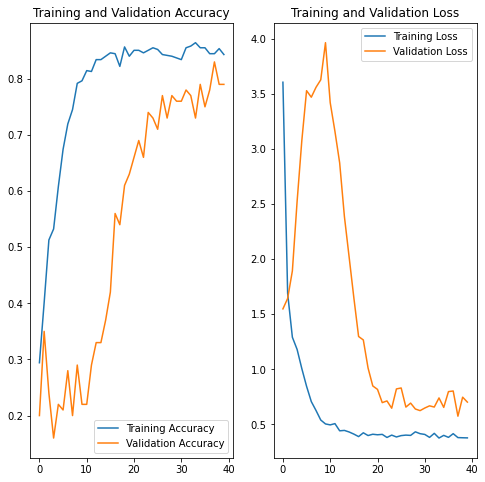

In [12]:
optimiser = Adam(learning_rate=0.001) 
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())
history= run_model(model_1, batch_size = batch_size, epoch_num= num_epochs, factor_ht=0, factor_wd=0)
loss(history)

This model is one of the best models that we have tried. In addition, the model is the lightest of all.

## Let's try with Conv-2d with RNN (LSTM and GRU)

### Model 2
- Switching Architecture to CNN + LSTM with Adam Optimizer

In [13]:
#write your model here
Input_shape = (15, img_size_ht,img_size_wd, 3)

lrelu = lambda x: LeakyReLU(alpha=0.1)(x)

model_2 = Sequential()

model_2.add(TimeDistributed(Conv2D(16, (3,3), padding = "same"), input_shape=(15,img_size_ht,img_size_wd,3)))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(Activation(lrelu)))
           
model_2.add(TimeDistributed(Conv2D(32,(3,3),padding = "same")))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(Activation(lrelu)))
model_2.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_2.add(TimeDistributed(Conv2D(64, (3,3),  padding = "same")))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(Activation(lrelu)))
model_2.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))
           
model_2.add(TimeDistributed(Conv2D(128,(3,3), padding = "same")))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(Activation(lrelu)))       
model_2.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_2.add(TimeDistributed(Conv2D(256,(3,3), padding = "same")))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(Activation(lrelu)))         
model_2.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))


model_2.add(TimeDistributed(Flatten()))
model_2.add(LSTM(256,dropout=0.2))
model_2.add(Dense(256, activation=lrelu))
model_2.add(Dropout(0.2))

model_2.add(Dense(5, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 120, 120, 16)  0        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 120, 120, 32)  4640     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 120, 120, 32)

Epoch 9/40
23/23 [==============================] - ETA: 0s - loss: 0.3285 - categorical_accuracy: 0.8808
Epoch 9: saving model to model_init_2022-04-1223_04_03.932231\model-00009-0.32854-0.88084-2.64962-0.26000.h5
23/23 [==============================] - 175s 8s/step - loss: 0.3285 - categorical_accuracy: 0.8808 - val_loss: 2.6496 - val_categorical_accuracy: 0.2600 - lr: 2.0000e-04
Epoch 10/40
23/23 [==============================] - ETA: 0s - loss: 0.2749 - categorical_accuracy: 0.9050
Epoch 10: saving model to model_init_2022-04-1223_04_03.932231\model-00010-0.27490-0.90498-2.52831-0.36000.h5
23/23 [==============================] - 174s 8s/step - loss: 0.2749 - categorical_accuracy: 0.9050 - val_loss: 2.5283 - val_categorical_accuracy: 0.3600 - lr: 2.0000e-04
Epoch 11/40
23/23 [==============================] - ETA: 0s - loss: 0.2474 - categorical_accuracy: 0.9170
Epoch 11: saving model to model_init_2022-04-1223_04_03.932231\model-00011-0.24740-0.91704-2.66034-0.28000.h5

Epoch 11

Epoch 30/40
23/23 [==============================] - ETA: 0s - loss: 0.0970 - categorical_accuracy: 0.9698
Epoch 30: saving model to model_init_2022-04-1223_04_03.932231\model-00030-0.09705-0.96983-0.55063-0.82000.h5
23/23 [==============================] - 173s 8s/step - loss: 0.0970 - categorical_accuracy: 0.9698 - val_loss: 0.5506 - val_categorical_accuracy: 0.8200 - lr: 8.0000e-06
Epoch 31/40
23/23 [==============================] - ETA: 0s - loss: 0.1013 - categorical_accuracy: 0.9744
Epoch 31: saving model to model_init_2022-04-1223_04_03.932231\model-00031-0.10129-0.97436-0.73532-0.80000.h5
23/23 [==============================] - 173s 8s/step - loss: 0.1013 - categorical_accuracy: 0.9744 - val_loss: 0.7353 - val_categorical_accuracy: 0.8000 - lr: 8.0000e-06
Epoch 32/40
23/23 [==============================] - ETA: 0s - loss: 0.0961 - categorical_accuracy: 0.9834
Epoch 32: saving model to model_init_2022-04-1223_04_03.932231\model-00032-0.09612-0.98341-0.63450-0.83000.h5
23/23 [

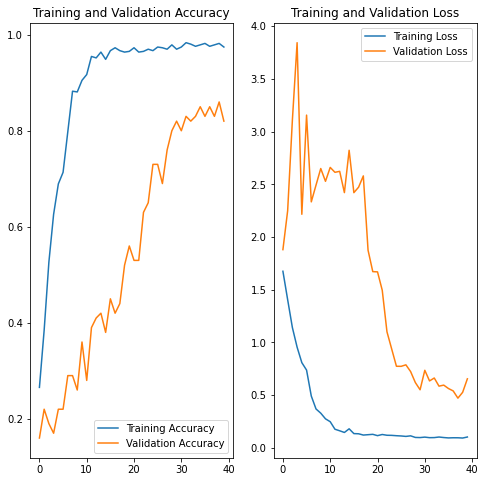

In [14]:
optimiser = RMSprop(learning_rate=0.001) 
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())
history= run_model(model_2, batch_size = batch_size, epoch_num= num_epochs, factor_ht=0, factor_wd=0)
loss(history)

The Validation Accuracy looks promising here. Also the loss seems to have stabalized. Model gave 0.86 validation accuracy. Only downside is that this model had 13.5 million paramters

### Model 3
- Trying out the above architecture but this time with **GRU**

In [15]:
#write your model here
Input_shape = (15, img_size_ht,img_size_wd, 3)

lrelu = lambda x: LeakyReLU(alpha=0.1)(x)

model_3 = Sequential()

model_3.add(TimeDistributed(Conv2D(16, (3,3), padding = "same"), input_shape=(15,img_size_ht,img_size_wd,3)))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(Activation(lrelu)))
           
model_3.add(TimeDistributed(Conv2D(32,(3,3),padding = "same")))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(Activation(lrelu)))
model_3.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_3.add(TimeDistributed(Conv2D(64, (3,3),  padding = "same")))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(Activation(lrelu)))
model_3.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))
           
model_3.add(TimeDistributed(Conv2D(128,(3,3), padding = "same")))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(Activation(lrelu)))       
model_3.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_3.add(TimeDistributed(Conv2D(256,(3,3), padding = "same")))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(Activation(lrelu)))         
model_3.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))


model_3.add(TimeDistributed(Flatten()))
model_3.add(GRU(256,dropout=0.2))
model_3.add(Dense(256, activation=lrelu))
model_3.add(Dropout(0.2))

model_3.add(Dense(5, activation='softmax'))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 15, 120, 120, 16)  0        
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 15, 120, 120, 32)  4640     
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 15, 120, 120, 32)

Epoch 9/40
23/23 [==============================] - ETA: 0s - loss: 0.5569 - categorical_accuracy: 0.7888
Epoch 9: saving model to model_init_2022-04-1223_04_03.932231\model-00009-0.55694-0.78884-3.77157-0.27000.h5
23/23 [==============================] - 170s 7s/step - loss: 0.5569 - categorical_accuracy: 0.7888 - val_loss: 3.7716 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 10/40
23/23 [==============================] - ETA: 0s - loss: 0.4463 - categorical_accuracy: 0.8431
Epoch 10: saving model to model_init_2022-04-1223_04_03.932231\model-00010-0.44634-0.84314-3.48369-0.27000.h5
23/23 [==============================] - 170s 7s/step - loss: 0.4463 - categorical_accuracy: 0.8431 - val_loss: 3.4837 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 11/40
23/23 [==============================] - ETA: 0s - loss: 0.3852 - categorical_accuracy: 0.8658
Epoch 11: saving model to model_init_2022-04-1223_04_03.932231\model-00011-0.38521-0.86576-3.14415-0.29000.h5
23/23 [==

Epoch 30/40
23/23 [==============================] - ETA: 0s - loss: 0.1638 - categorical_accuracy: 0.9532
Epoch 30: saving model to model_init_2022-04-1223_04_03.932231\model-00030-0.16376-0.95324-0.65523-0.80000.h5
23/23 [==============================] - 168s 7s/step - loss: 0.1638 - categorical_accuracy: 0.9532 - val_loss: 0.6552 - val_categorical_accuracy: 0.8000 - lr: 8.0000e-06
Epoch 31/40
23/23 [==============================] - ETA: 0s - loss: 0.1563 - categorical_accuracy: 0.9608
Epoch 31: saving model to model_init_2022-04-1223_04_03.932231\model-00031-0.15628-0.96078-0.64838-0.83000.h5
23/23 [==============================] - 170s 7s/step - loss: 0.1563 - categorical_accuracy: 0.9608 - val_loss: 0.6484 - val_categorical_accuracy: 0.8300 - lr: 8.0000e-06
Epoch 32/40
23/23 [==============================] - ETA: 0s - loss: 0.1596 - categorical_accuracy: 0.9502
Epoch 32: saving model to model_init_2022-04-1223_04_03.932231\model-00032-0.15956-0.95023-0.58493-0.84000.h5
23/23 [

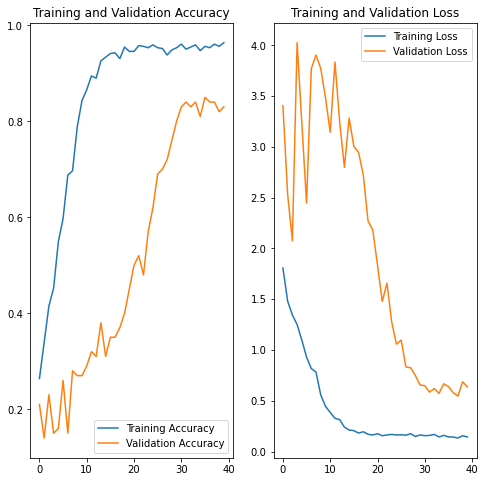

In [16]:
optimiser = RMSprop(learning_rate=0.001) 
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())
history= run_model(model_3, batch_size = batch_size, epoch_num= num_epochs, factor_ht=0, factor_wd=0)
loss(history)

We can see almost similar result as with LSTM. However the model is lighter than LSTM but still there are 10.3 million parameters in this model.

## Trying out with Transfer Learning now

### Model 4
- Try out with Transfer Learning. We will try with the **EfficientNetB0**
- We have used GRU as this architecture is lighter

In [17]:
model_4 = Sequential()
model_4.add(TimeDistributed(EfficientNetB0(weights='imagenet', include_top=False),input_shape=(15,img_size_ht,img_size_wd,3)))

for layer in model_4.layers:
    layer.trainable = False

model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_4.add(TimeDistributed(Flatten()))

model_4.add(GRU(256))
model_4.add(Dropout(0.2))

model_4.add(Dense(256,activation='elu'))
model_4.add(Dropout(0.2))

model_4.add(Dense(5, activation='softmax'))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  (None, 15, 3, 3, 1280)   4049571   
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 15, 3, 3, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 15, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 15, 1280)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 256)              

23/23 [==============================] - 97s 4s/step - loss: 1.7016 - categorical_accuracy: 0.1735 - val_loss: 1.6333 - val_categorical_accuracy: 0.2200 - lr: 4.0000e-05
Epoch 17/40
23/23 [==============================] - ETA: 0s - loss: 1.6951 - categorical_accuracy: 0.1961
Epoch 17: saving model to model_init_2022-04-1223_04_03.932231\model-00017-1.69510-0.19608-1.60801-0.23000.h5
23/23 [==============================] - 99s 4s/step - loss: 1.6951 - categorical_accuracy: 0.1961 - val_loss: 1.6080 - val_categorical_accuracy: 0.2300 - lr: 4.0000e-05
Epoch 18/40
23/23 [==============================] - ETA: 0s - loss: 1.6455 - categorical_accuracy: 0.2278
Epoch 18: saving model to model_init_2022-04-1223_04_03.932231\model-00018-1.64547-0.22775-1.59755-0.29000.h5
23/23 [==============================] - 99s 4s/step - loss: 1.6455 - categorical_accuracy: 0.2278 - val_loss: 1.5976 - val_categorical_accuracy: 0.2900 - lr: 4.0000e-05
Epoch 19/40
23/23 [==============================] - ETA

23/23 [==============================] - 98s 4s/step - loss: 1.6806 - categorical_accuracy: 0.2066 - val_loss: 1.6057 - val_categorical_accuracy: 0.2300 - lr: 1.6000e-06
Epoch 38/40
23/23 [==============================] - ETA: 0s - loss: 1.6775 - categorical_accuracy: 0.1991
Epoch 38: saving model to model_init_2022-04-1223_04_03.932231\model-00038-1.67745-0.19910-1.60471-0.23000.h5

Epoch 38: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
23/23 [==============================] - 97s 4s/step - loss: 1.6775 - categorical_accuracy: 0.1991 - val_loss: 1.6047 - val_categorical_accuracy: 0.2300 - lr: 1.6000e-06
Epoch 39/40
23/23 [==============================] - ETA: 0s - loss: 1.6877 - categorical_accuracy: 0.1961
Epoch 39: saving model to model_init_2022-04-1223_04_03.932231\model-00039-1.68766-0.19608-1.60814-0.20000.h5
23/23 [==============================] - 98s 4s/step - loss: 1.6877 - categorical_accuracy: 0.1961 - val_loss: 1.6081 - val_categorical_accuracy: 0.

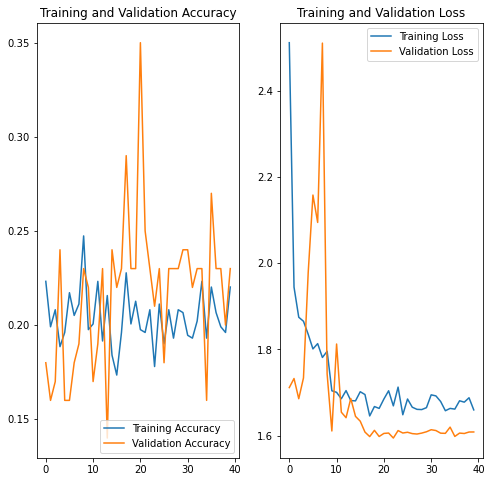

In [18]:
optimiser = RMSprop(learning_rate=0.001) 
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())
history= run_model(model_4, batch_size = batch_size, epoch_num= num_epochs, factor_ht=0, factor_wd=0)
loss(history)

Although the accuracy is not high, but the model is not too overfit as seen in most of the earlier models. Now since the model gave very low accuracy so the model would be discarded.

### Model 5

- Trying out Transfer Learning with **Mobile Net**.

In [19]:
from keras.applications import mobilenet

In [20]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model_5 = Sequential()
model_5.add(TimeDistributed(mobilenet_transfer,input_shape=(15,img_size_ht,img_size_wd,3)))


for layer in model_5.layers:
    layer.trainable = False


model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
model_5.add(TimeDistributed(Flatten()))

model_5.add(GRU(256))
model_5.add(Dropout(0.2))

model_5.add(Dense(256,activation='elu'))
model_5.add(Dropout(0.2))

model_5.add(Dense(5, activation='softmax'))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 256)              

Epoch 17/40
23/23 [==============================] - ETA: 0s - loss: 0.0032 - categorical_accuracy: 0.9970    
Epoch 17: saving model to model_init_2022-04-1223_04_03.932231\model-00017-0.00321-0.99698-0.86631-0.79000.h5
23/23 [==============================] - 77s 3s/step - loss: 0.0032 - categorical_accuracy: 0.9970 - val_loss: 0.8663 - val_categorical_accuracy: 0.7900 - lr: 2.0000e-04
Epoch 18/40
23/23 [==============================] - ETA: 0s - loss: 1.7642e-04 - categorical_accuracy: 1.0000
Epoch 18: saving model to model_init_2022-04-1223_04_03.932231\model-00018-0.00018-1.00000-0.92444-0.81000.h5
23/23 [==============================] - 78s 3s/step - loss: 1.7642e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9244 - val_categorical_accuracy: 0.8100 - lr: 2.0000e-04
Epoch 19/40
23/23 [==============================] - ETA: 0s - loss: 2.3617e-04 - categorical_accuracy: 1.0000
Epoch 19: saving model to model_init_2022-04-1223_04_03.932231\model-00019-0.00024-1.00000-0.85358-0.80

Epoch 37/40
23/23 [==============================] - ETA: 0s - loss: 1.5512e-04 - categorical_accuracy: 1.0000
Epoch 37: saving model to model_init_2022-04-1223_04_03.932231\model-00037-0.00016-1.00000-0.81178-0.82000.h5
23/23 [==============================] - 77s 3s/step - loss: 1.5512e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8118 - val_categorical_accuracy: 0.8200 - lr: 3.2000e-07
Epoch 38/40
23/23 [==============================] - ETA: 0s - loss: 4.6163e-05 - categorical_accuracy: 1.0000
Epoch 38: saving model to model_init_2022-04-1223_04_03.932231\model-00038-0.00005-1.00000-0.76486-0.85000.h5
23/23 [==============================] - 77s 3s/step - loss: 4.6163e-05 - categorical_accuracy: 1.0000 - val_loss: 0.7649 - val_categorical_accuracy: 0.8500 - lr: 3.2000e-07
Epoch 39/40
23/23 [==============================] - ETA: 0s - loss: 8.8520e-05 - categorical_accuracy: 1.0000
Epoch 39: saving model to model_init_2022-04-1223_04_03.932231\model-00039-0.00009-1.00000-0.80346-

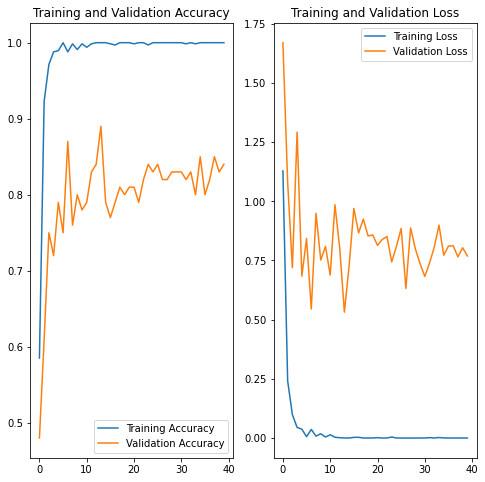

In [21]:
optimiser = RMSprop(learning_rate=0.001) 
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())
history= run_model(model_5, batch_size = batch_size, epoch_num= num_epochs, factor_ht=0, factor_wd=0)
loss(history)

This model showed the most promising results. We can consider using this as our final model. Only downside here is the number of parameters which is 42 million even though it gave the higest validation accuracy till now of 0.89. <br><br>

### Model 6

#### Calling Model 1 with Data Augmentation

Source path =  Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 0.3989 - categorical_accuracy: 0.8492Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-04-1223_04_03.932231\model-00001-0.39885-0.84917-0.74665-0.76000.h5
23/23 [==============================] - 157s 7s/step - loss: 0.3989 - categorical_accuracy: 0.8492 - val_loss: 0.7466 - val_categorical_accuracy: 0.7600 - lr: 1.6000e-06
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 0.4158 - categorical_accuracy: 0.8386
Epoch 2: saving model to model_init_2022-04-1223_04_03.932231\model-00002-0.41580-0.83861-0.72971-0.77000.h5
23/23 [==============================] - 157s 7s/step - loss: 0.4158 - categorical_accuracy: 0.8386 - val_loss: 0.7297 - val_categorical_accuracy: 0.7700 - lr: 1.6000e-06
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 0.4364 - categorical_accuracy: 0.8250
Epoch 3: saving mode

23/23 [==============================] - 157s 7s/step - loss: 0.4319 - categorical_accuracy: 0.8265 - val_loss: 0.6837 - val_categorical_accuracy: 0.8300 - lr: 3.2000e-07
Epoch 22/40
23/23 [==============================] - ETA: 0s - loss: 0.4068 - categorical_accuracy: 0.8416
Epoch 22: saving model to model_init_2022-04-1223_04_03.932231\model-00022-0.40677-0.84163-0.70172-0.82000.h5
23/23 [==============================] - 157s 7s/step - loss: 0.4068 - categorical_accuracy: 0.8416 - val_loss: 0.7017 - val_categorical_accuracy: 0.8200 - lr: 3.2000e-07
Epoch 23/40
23/23 [==============================] - ETA: 0s - loss: 0.4210 - categorical_accuracy: 0.8446
Epoch 23: saving model to model_init_2022-04-1223_04_03.932231\model-00023-0.42097-0.84465-0.66780-0.80000.h5

Epoch 23: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
23/23 [==============================] - 157s 7s/step - loss: 0.4210 - categorical_accuracy: 0.8446 - val_loss: 0.6678 - val_categorical_accuracy:

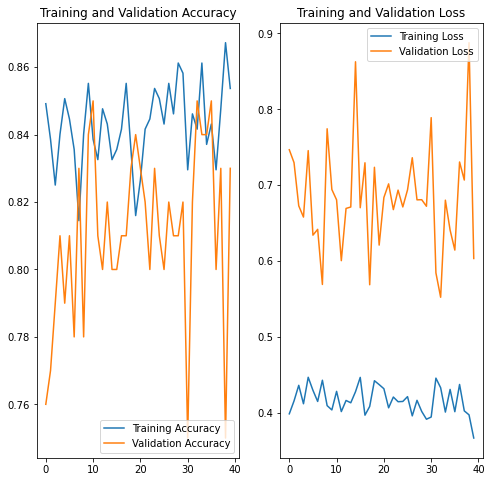

In [22]:
# optimiser = RMSprop(learning_rate=0.001) 
# model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model_1.summary())
history= run_model(model_1, batch_size = batch_size, epoch_num= num_epochs, factor_ht=10, factor_wd=10)
loss(history)

The model gave 0.85 accuracy and the model is certianly very light. We will consider this our final model.

#### Running GRU model with augmentation

Source path =  Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 0.1567 - categorical_accuracy: 0.9472
Epoch 1: saving model to model_init_2022-04-1311_05_16.386871\model-00001-0.15667-0.94721-0.70487-0.78000.h5
23/23 [==============================] - 173s 8s/step - loss: 0.1567 - categorical_accuracy: 0.9472 - val_loss: 0.7049 - val_categorical_accuracy: 0.7800 - lr: 1.2800e-08
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 0.1481 - categorical_accuracy: 0.9623
Epoch 2: saving model to model_init_2022-04-1311_05_16.386871\model-00002-0.14805-0.96229-0.66677-0.78000.h5
23/23 [==============================] - 173s 8s/step - loss: 0.1481 - categorical_accuracy: 0.9623 - val_loss: 0.6668 - val_categorical_accuracy: 0.7800 - lr: 1.2800e-08
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 0.1640 - categorical_accuracy: 0.9472
Epoch 3: saving model to model_init_2022-04-1311_05_16.386871\model-00

23/23 [==============================] - 172s 7s/step - loss: 0.1602 - categorical_accuracy: 0.9427 - val_loss: 0.6703 - val_categorical_accuracy: 0.8000 - lr: 5.1200e-10
Epoch 22/40
23/23 [==============================] - ETA: 0s - loss: 0.1478 - categorical_accuracy: 0.9548
Epoch 22: saving model to model_init_2022-04-1311_05_16.386871\model-00022-0.14778-0.95475-0.63197-0.81000.h5
23/23 [==============================] - 175s 8s/step - loss: 0.1478 - categorical_accuracy: 0.9548 - val_loss: 0.6320 - val_categorical_accuracy: 0.8100 - lr: 5.1200e-10
Epoch 23/40
23/23 [==============================] - ETA: 0s - loss: 0.1519 - categorical_accuracy: 0.9532
Epoch 23: saving model to model_init_2022-04-1311_05_16.386871\model-00023-0.15186-0.95324-0.77100-0.79000.h5

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.0240001069306004e-10.
23/23 [==============================] - 176s 8s/step - loss: 0.1519 - categorical_accuracy: 0.9532 - val_loss: 0.7710 - val_categorical_accuracy

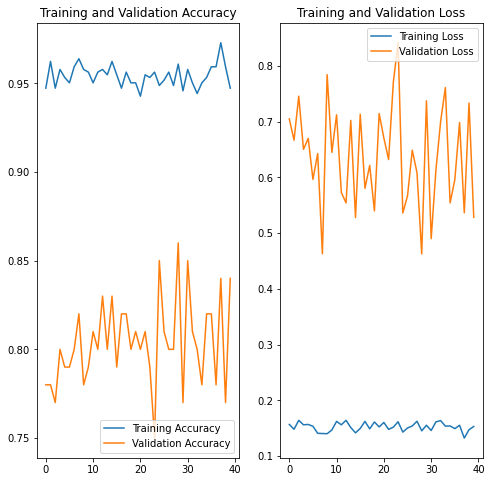

In [31]:
history= run_model(model_3, batch_size = batch_size, epoch_num= num_epochs, factor_ht=10, factor_wd=10)
loss(history)

This model gave 0.86 validation accuracy but since this is very heavy model so would not be considered.

## Final Model:

### Model 1

- Train Accuracy = 0.84
- Val Accuracy = 0.85
- Model File name - model-00036-0.40165-0.84314-0.61451-0.85000.h5